In [1]:
import gc
import gc, re
import time
import numpy as np
import xgboost as xgb
import pickle
import cx_Oracle as orcl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from datetime import datetime
from matplotlib import rc
from sklearn.svm import l1_min_c
#from sklearn.cross_validation import cross_val_score,train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,precision_recall_curve,auc
from sklearn.metrics import make_scorer, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import lasso_path, enet_path,LassoCV, LassoLarsCV, LassoLarsIC
#from sklearn import cross_validation,ensemble, datasets, grid_search, linear_model, metrics,tree


from itertools import cycle

'''
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 1300)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
'''

"\npd.set_option('display.height', 1000)\npd.set_option('display.max_rows', 1300)\npd.set_option('display.max_columns', 500)\npd.set_option('display.width', 1000)\n"

In [5]:
import cx_Oracle
con1 = cx_Oracle.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')

In [6]:
%%time
import pandas as pd
sql_str1 ='''
SELECT * FROM t_rs_nonelig_cash_train

'''
df = pd.read_sql_query(sql_str1, con1)
df_query = df.copy()

CPU times: user 5min 5s, sys: 18.7 s, total: 5min 24s
Wall time: 5min 29s


In [7]:
df.sort_values(by=['MONTH_'],ascending=True,inplace=True)
df_query.sort_values(by=['MONTH_'],ascending=True,inplace=True)
df.rename(columns={'FLAG_CASH':'FLAG_APPLICATION'},inplace=True)
df_query.rename(columns={'FLAG_CASH':'FLAG_APPLICATION'},inplace=True)
df_query.reset_index(drop=True,inplace=True)
df.reset_index(drop=True,inplace=True)

In [8]:
df_query.shape

(576480, 599)

In [9]:
df_query.head(2)

,SKP_CLIENT,MONTH_,SD_AGE,SD_FLAG_PENSIONER,SD_NAME_CITY,SD_AMT_INCOME_MAIN,SD_AMT_INCOME_OTHER,SD_PREFERRED_LANGUAGE,SD_AGE_MONTH,SD_CODE_GENDER,...,FCB_CNT_CONTRACT_CAR,FCB_CNT_CONTRACT_MOR,FCB_CNT_CONTRACT_BIZ,FCB_CNT_CONTRACT_ACT,FCB_CNT_CONTRACT_LOAN_ACT,FCB_CNT_CONTRACT_CARD_ACT,FCB_CNT_CONTRACT_CAR_ACT,FCB_CNT_CONTRACT_MOR_ACT,FCB_CNT_CONTRACT_BIZ_ACT,FLAG_APPLICATION
0,2594535,2019-02-01,31.5,N,Кызылорда,250000.0,0.0,Казахский,377.68,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,12926461,2019-02-01,66.7,Y,Шар,280000.0,0.0,Казахский,800.16,M,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [10]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd
import gc, re

def prepare_df (df, isPrintFeatures=True, isGetDummies = True, isPrintDummies=True, trsh_hold=0.001):
    drop_feat_hcode = [
        #id
        'MONTH_',                                        
        'SKP_CLIENT',
        'CMP_DATE_VALID_FROM',
        'CMP_DATE_VALID_TO',
        'LC_DATE_LAST_PAYMENT',
        
        'CMP_NAME',
        'CMP_RISK_GRADE',
        'SD_PREFERRED_LANGUAGE',
        
        'CMP_AMT_OFFER',
        'LC_CREDIT_STATUS',
        'LA_CREDIT_STATUS',
        'LC_CREDIT_STATUS_GROUP',
        'LA_CREDIT_STATUS_GROUP',
        
        'CON_IR_AVG',
        'CON_IR_AVG_CASH',
        'CON_IR_AVG_POS',
        'CON_IR_MAX',
        'CON_IR_MIN',
        'CON_IR_MAX_POS',
        'CON_IR_MIN_POS',
        'CON_IR_MAX_CASH',
        'CON_IR_MIN_CASH',
        'CON_SHARE_IR_MED_LAST_1',
        'CON_SHARE_IR_MED_LAST_2',
        'CON_SHARE_IR_MED_LAST_3',
        'CON_SHARE_IR_AVG_MED',
        'CON_SHARE_IR_MED_LAST_1_POS',
        'CON_SHARE_IR_MED_LAST_2_POS',
        'CON_SHARE_IR_MED_LAST_3_POS',
        'CON_SHARE_IR_AVG_MED_POS',
        'CON_SHARE_IR_MED_LAST_1_CASH',
        'CON_SHARE_IR_MED_LAST_2_CASH',
        'CON_SHARE_IR_MED_LAST_3_CASH',
        'CON_SHARE_IR_AVG_MED_CASH',

              
        
         'FCB_CNT_APP_1M',
         'FCB_CNT_APP_3M',
         'FCB_CNT_APP_6M',
         'FCB_CNT_APP_12M',
         'FCB_CNT_M_FIRST_OPEN',
         'FCB_CNT_M_LAST_OPEN',
         'FCB_CNT_M_LAST_CLOSE',
         'FCB_AVG_TERM_PLAN',
         'FCB_AVG_TERM_FACT',
         'FCB_MIN_AMT_CREDIT',
         'FCB_MAX_AMT_CREDIT',
         'FCB_AVG_AMT_CREDIT',
         'FCB_SUM_AMT_CREDIT_W_MOR',
         'FCB_SUM_AMT_CREDIT_W_O_MOR',
         'FCB_SUM_ANNUITY_W_MOR',
         'FCB_SUM_ANNUITY_W_O_MOR',
         'FCB_CNT_OVERDUE',
         'FCB_MAX_OVERDUE',
         'FCB_CNT_EARLY_CLOSE',
         'FCB_CNT_CONTRACT',
         'FCB_CNT_CONTRACT_LOAN',
         'FCB_CNT_CONTRACT_CARD',
         'FCB_CNT_CONTRACT_CAR',
         'FCB_CNT_CONTRACT_MOR',
         'FCB_CNT_CONTRACT_BIZ',
         'FCB_CNT_CONTRACT_ACT',
         'FCB_CNT_CONTRACT_LOAN_ACT',
         'FCB_CNT_CONTRACT_CARD_ACT',
         'FCB_CNT_CONTRACT_CAR_ACT',
         'FCB_CNT_CONTRACT_MOR_ACT',
         'FCB_CNT_CONTRACT_BIZ_ACT'
        #'CMP_DATE_VALID_FROM',    
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT',
        #1
        #'CNT_CAMPAIGN',
        #'CNT_CAMPAIGN_TERM_MONTH',
        #1
        #2
        #'RATE_EIR_AVG',
        #'RATE_EIR_LOAN_FIRST',
        #'RATE_EIR_LOAN_LAST',
        #'RATE_EIR_PREV_LOAN_MAX',
        #'RATE_INTEREST_LOAN_LAST',
        #2
        #даты
        #'DATE_BCKT_1_30_OVD_LAST',
        #'DATE_BCKT_31_60_OVD_LAST',
        #'DATE_BCKT_61_90_OVD_LAST',
        #'DATE_BIRTH',
        #'DATE_TRAN_CARD_CASH_LAST',
        #'DATE_TRAN_CARD_POS_LAST'
        ]
    df.drop(drop_feat_hcode, axis=1, inplace=True)

    # Cat Features 
    # преобразовываем int to obj
    #df = df.rename(index=str, columns={"OF_CODE_SEGMENT_NEW": "OF_CODE_SEGMENT_NEW_"})

    #flag_to_obj = ['CON_NFLAG_PCCD_ALL_N','CON_NFLAG_PCCD_ACT_N', 'OF_CODE_SEGMENT_NEW_']
    #df[flag_to_obj] = df[flag_to_obj].astype(str)
    flag_to_obj = []
    
    cat_feat_objects = df.columns[df.dtypes=='object']
    #cat_feat_objects = np.concatenate([cat_feat_objects,['OF_CODE_SEGMENT_NEW_']])
    #cat_feat_nflag = df.filter(regex='.*FLAG_').columns
    #cat_feat_nflag = [x for x in cat_feat_nflag if x not in flag_to_obj]

    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(int)
    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(str)

    #cat_feat_SK = df.filter(regex='.*SK.?_').columns
    #df[cat_feat_SK]=df[cat_feat_SK].astype(int)
    #df[cat_feat_SK]=df[cat_feat_SK].astype(str)

    cat_feat_all = list(set().union(cat_feat_objects))
    cat_feat_all.sort()

    df_categ_feat_ind = np.where(np.in1d(df.columns,cat_feat_all))[0]

    #isPrintFeatures= True
    if isPrintFeatures == True:
        print('[cat_feat_objects]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_objects) )
        print ('\n')

        print('[cat_feat_nflag]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_nflag) )
        print ('\n')

        print('[cat_feat_SK]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_SK) )
        print ('\n')

        print('[cat_feat_all]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_all) )
        print ('\n')

    #isGetDummies = True
    # Get Dummies
    df_dummy_categ_feat_ind = np.zeros([1])
    if isGetDummies == True:
        cat_feat_all_dumm = pd.get_dummies(df[cat_feat_all])

        #isPrintDummies= True
        if isPrintDummies == True:
            print('#' * 80)
            print('Count dummies columns')
            print(len(cat_feat_all_dumm.columns))
            #print(list(cat_feat_all_dumm.columns))

        #trsh_hold = 0.001 if 0 - all variables
        #VarianceThreshold for CatFeatures
        VT = VarianceThreshold(threshold=trsh_hold)
        VT.fit(cat_feat_all_dumm)
        VT_mask = VT.get_support()
        print( '{} features left'.format(VT_mask.sum()))
        print( '\n'.join(str(p) for p in cat_feat_all_dumm.columns[VT_mask]))

        #объединяем        
        df.drop(cat_feat_all, axis=1, inplace=True)
        df = pd.concat([df, cat_feat_all_dumm[cat_feat_all_dumm.columns[VT_mask]]], axis=1)

        df_dummy_categ_feat_ind = np.where(np.in1d(df.columns, cat_feat_all_dumm.columns[VT_mask]))[0]

        #убираем спец символы из названий столбцов категорий
        df.rename(columns=lambda x: x.replace('-', '_minus'), inplace=True)
        df.rename(columns=lambda x: x.replace('+', '_plus'), inplace=True)
        df.rename(columns=lambda x: re.sub(r"[\W ]", '_', x), inplace=True)
    return df, df_categ_feat_ind, df_dummy_categ_feat_ind

In [11]:
%%time
df, _ , _ = prepare_df(df, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)

425 features left
CMP_TYPE_GROUP_CE
CMP_TYPE_GROUP_XS
CMP_TYPE_PRODUCT_CARD
CMP_TYPE_PRODUCT_CASH
CMP_TYPE_PRODUCT_REFINANCE
COM_LAST_CALL_DEPT_0
COM_LAST_CALL_DEPT_7373
COM_LAST_CALL_DEPT_7979
COM_LAST_CALL_DEPT_Credit-cards
COM_LAST_CALL_DEPT_Infoline
COM_LAST_CALL_DEPT_Infoline2
COM_LAST_CALL_DEPT_Marketing
COM_LAST_CALL_DEPT_Online-anketa
COM_LAST_CALL_DEPT_X-Sell вх
COM_LAST_CALL_DEPT_X-sell
COM_LAST_CALL_STATUS_0
COM_LAST_CALL_STATUS_Answer
COM_LAST_CALL_STATUS_Исключение номера из обработки
COM_LAST_CALL_STATUS_Неопределен
COM_LAST_CALL_STATUS_Перезвонить позже
COM_LAST_CALL_STATUS_Успех
CON_CNT_PCC_ALL_001
CON_CNT_PCC_ALL_010
CON_CNT_PCC_ALL_011
CON_CNT_PCC_ALL_020
CON_CNT_PCC_ALL_021
CON_CNT_PCC_ALL_030
CON_CNT_PCC_ALL_040
CON_CNT_PCC_ALL_050
CON_CNT_PCC_ALL_060
CON_CNT_PCC_ALL_070
CON_CNT_PCC_ALL_080
CON_CNT_PCC_ALL_100
CON_CNT_PCC_ALL_101
CON_CNT_PCC_ALL_102
CON_CNT_PCC_ALL_110
CON_CNT_PCC_ALL_111
CON_CNT_PCC_ALL_120
CON_CNT_PCC_ALL_121
CON_CNT_PCC_ALL_130
CON_CNT_PCC_ALL_14

In [12]:
df.shape

(576480, 911)

In [13]:
df_query.shape

(576480, 599)

# Select Features

In [14]:
from scipy.stats import linregress

def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2


def correlation(dataset, threshold, method='pearson'):
    start = time.clock()
    dataset_in=dataset.copy()
    Y = dataset_in.FLAG_APPLICATION
    dataset_in.drop(['FLAG_APPLICATION'],axis=1, inplace=True)
    
    X_Train_r2=[]
    for idx, name in  enumerate(dataset_in.columns):
        X_Train_r2.append([name,rsquared(dataset_in[name].values, Y)])
    X_Train_r2=pd.DataFrame(X_Train_r2, columns=['NAME','R2'], index=np.array(X_Train_r2)[:,0])

    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset_in.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname_row = corr_matrix.index[j] # getting the name of index(row name)
                colname_col = corr_matrix.columns[i] # getting the name of column
                if X_Train_r2.loc[colname_row].R2> X_Train_r2.loc[colname_col].R2:
                    colname=colname_col
                else:
                    colname=colname_row
                col_corr.add(colname)
                if colname in dataset_in.columns:
                    del dataset_in[colname] # deleting the column from the dataset
    end = time.clock()
    print( "%.2gs" % (end-start))
    return dataset_in, col_corr, corr_matrix

In [ ]:
%%time
df_ncr, col_corr, corr_matrix=correlation(df, 0.7,method='spearman')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


In [28]:
df.shape

(576480, 911)

In [27]:
df_ncr.shape

(576480, 539)

In [ ]:
features_name = df_ncr.columns

In [ ]:
target = df.FLAG_APPLICATION

X_train, X_temp, Y_train, Y_temp = train_test_split( df_ncr
                                                    , target
                                                    , test_size=0.30, stratify=target
                                                    , random_state=123)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=456)

print ('Mean target: ', target.mean())
print ('Train', (X_train.shape, Y_train.mean(), Y_train.sum()))
print ('Temp ', (X_temp.shape, Y_temp.mean(), Y_temp.sum())) # just for info
print ('Vali ', (X_val.shape, Y_val.mean(), Y_val.sum()))
print ('Test ', (X_test.shape, Y_test.mean(), Y_test.sum()))

In [22]:
%%time
clf = xgb.XGBClassifier(n_estimators=5000,nthread=8)
eval_set = [(X_train, Y_train), (X_val, Y_val)]
clf.fit(X_train, 
        Y_train,
        eval_set=eval_set,
        eval_metric="auc", 
        early_stopping_rounds=50,
        verbose=True)

[0]	validation_0-auc:0.73746	validation_1-auc:0.73490
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.74622	validation_1-auc:0.74293
[2]	validation_0-auc:0.74940	validation_1-auc:0.74566
[3]	validation_0-auc:0.75161	validation_1-auc:0.74782
[4]	validation_0-auc:0.75387	validation_1-auc:0.74988
[5]	validation_0-auc:0.75588	validation_1-auc:0.75164
[6]	validation_0-auc:0.75776	validation_1-auc:0.75312
[7]	validation_0-auc:0.76016	validation_1-auc:0.75535
[8]	validation_0-auc:0.76167	validation_1-auc:0.75636
[9]	validation_0-auc:0.76364	validation_1-auc:0.75791
[10]	validation_0-auc:0.76528	validation_1-auc:0.75916
[11]	validation_0-auc:0.76697	validation_1-auc:0.76033
[12]	validation_0-auc:0.76816	validation_1-auc:0.76117
[13]	validation_0-auc:0.76942	validation_1-auc:0.76212
[14]	validation_0-auc:0.77048	validation_1-auc:0.76268
[15]	validation_0-auc:0.7716

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=5000, n_jobs=8, nthread=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [23]:
f = 0
auc_train = roc_auc_score(Y_train, clf.predict_proba(X_train)[:,1])
auc_valid = roc_auc_score(Y_val, clf.predict_proba(X_val)[:,1])
auc_test    = roc_auc_score(Y_test, clf.predict_proba(X_test)[:,1])
#print("{f} auc_train:{auc_train} auc_valid:{auc_valid}")
print(f"train:{auc_train} valid:{auc_valid} test:{auc_test}")

train:0.8017146234252159 valid:0.7714768355050325 test:0.7718951925047266


In [24]:
import shap

In [25]:
%%time
shap_test = shap.TreeExplainer(clf).shap_values(df_ncr)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 23min 57s, sys: 2.35 s, total: 24min
Wall time: 3min 35s


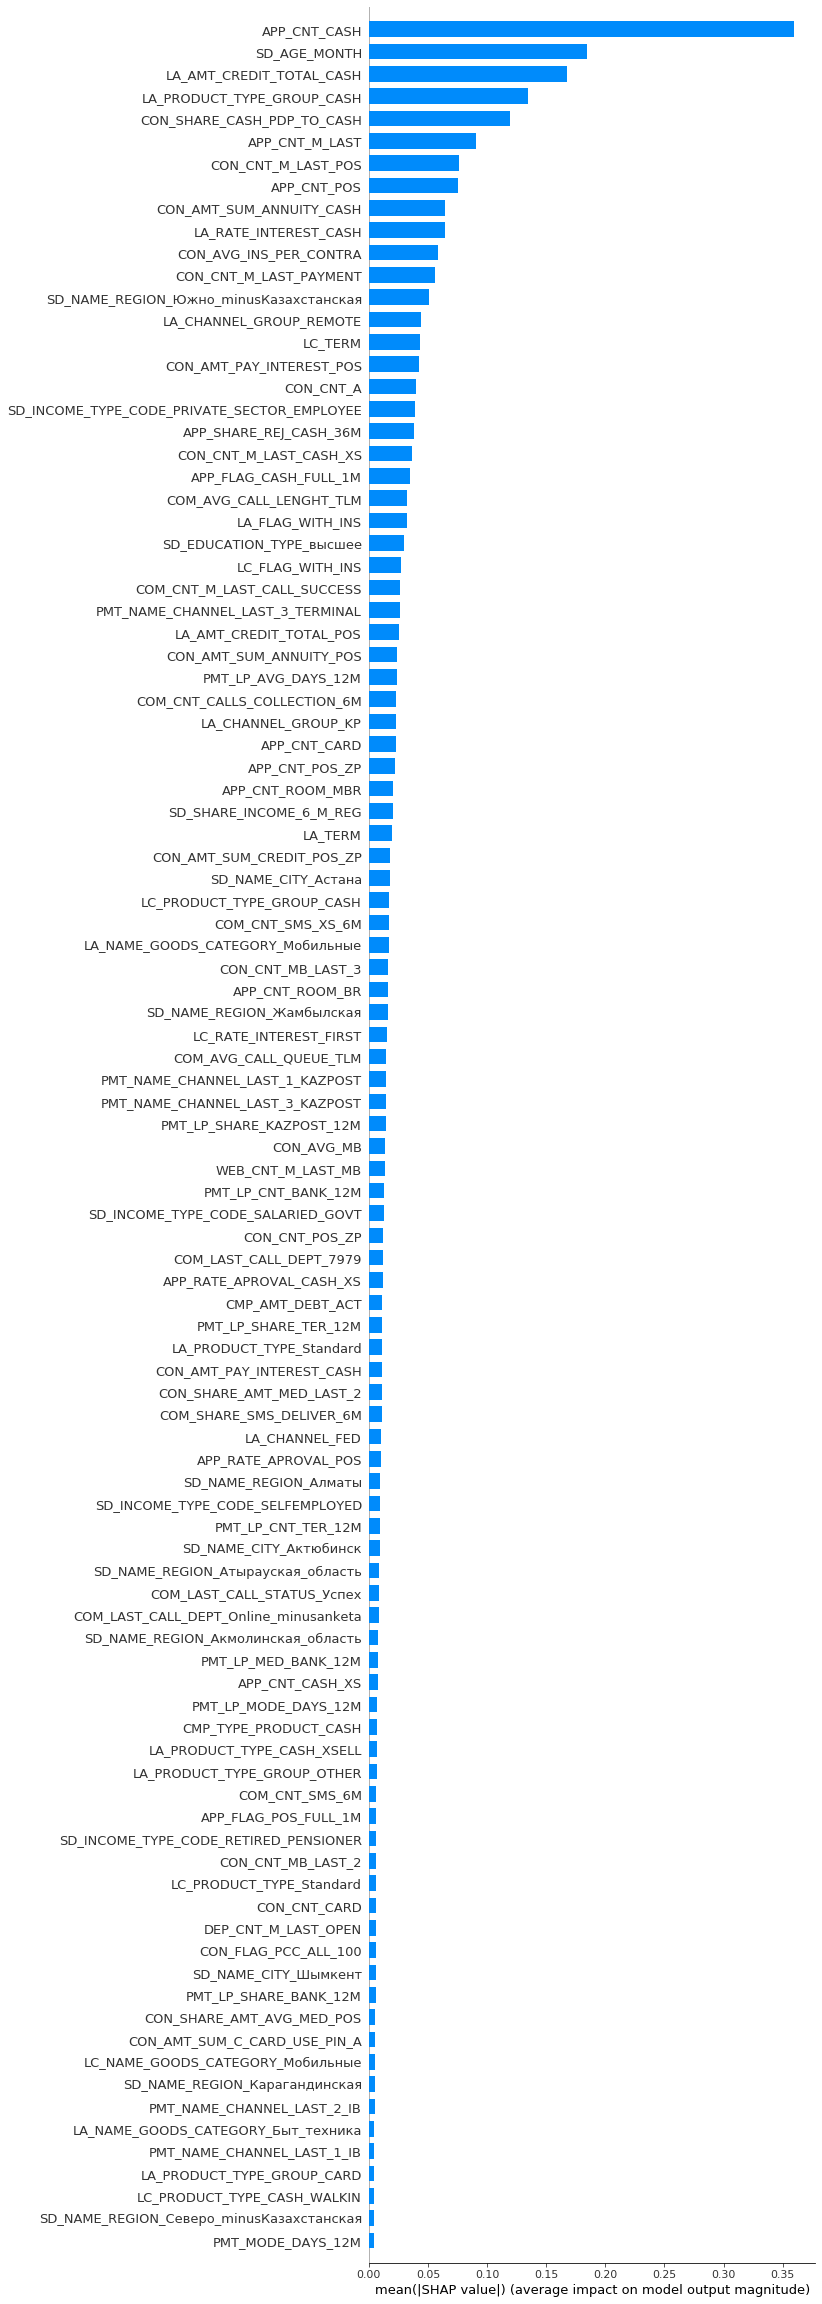

CPU times: user 3.48 s, sys: 907 ms, total: 4.39 s
Wall time: 4.4 s


In [26]:
%%time
shap.summary_plot(shap_test,df_ncr,max_display=100, plot_type="bar")

# Hyperopt, cross validation by time

In [49]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [89]:
def custom_cv(k):
    #k=5 #folds
    i=len(df_query.MONTH_.unique())-k
    while i<len(df_query.MONTH_.unique()):
        train_ind=df_query[np.in1d(np.array(df_query.MONTH_),df_query.MONTH_.unique()[:i])].index.tolist()
        test_ind=df_query[np.in1d(np.array(df_query.MONTH_),df_query.MONTH_.unique()[i:i+1])].index.tolist()
        yield train_ind,test_ind
        i+=1

In [118]:
for i,j in custom_cv(3):
    print(df_query.MONTH_.iloc[i[0]],'--',df_query.MONTH_.iloc[i[-1]])
    print(df_query.MONTH_.iloc[j[0]],'--',df_query.MONTH_.iloc[j[-1]])
    print('-----')
    

2019-02-01 00:00:00 -- 2019-09-01 00:00:00
2019-10-01 00:00:00 -- 2019-10-01 00:00:00
-----
2019-02-01 00:00:00 -- 2019-10-01 00:00:00
2019-11-01 00:00:00 -- 2019-11-01 00:00:00
-----
2019-02-01 00:00:00 -- 2019-11-01 00:00:00
2019-12-01 00:00:00 -- 2019-12-01 00:00:00
-----


In [129]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, df_ncr, target, scoring='roc_auc',cv=custom_cv(3)).mean()
    print(current_score, params)
    score_xgb.append(current_score)
    params_xgb.append(params)
    return 1-current_score

In [130]:
score_xgb=[]
params_xgb=[]

In [131]:
space_xgb = {
            'n_estimators': 100,#hp.choice('n_estimators', range(100, 3000)),
            'eta':hp.quniform('learning_rate', 0.001, 0.1, 0.001),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
            'min_child_weight': hp.choice('min_child_weight', np.arange(1, 300, dtype=int)),
            'subsample': hp.uniform ('subsample', 0.5, 1),
            'gamma': hp.uniform ('gamma', 0, 5),
            'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1),
            'reg_alpha': hp.uniform ('reg_alpha', 1e-05,1),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            # Increase this number if you have more cores. Otherwise, remove it and it will default
            # to the maxium number.
            'nthread': 8,
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1
        }

In [132]:
%%time
x1=time.time()
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=100)
x2=time.time()

0.7423148860165235                                     
{'booster': 'gbtree', 'colsample_bytree': 0.653473127557145, 'eta': 0.066, 'eval_metric': 'auc', 'gamma': 4.862909865924708, 'max_depth': 1, 'min_child_weight': 133, 'n_estimators': 100, 'nthread': 8, 'objective': 'binary:logistic', 'reg_alpha': 0.7885753145256993, 'silent': 1, 'subsample': 0.5614407527317933, 'tree_method': 'exact'}
0.7553472907446656                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.8582556253176414, 'eta': 0.036000000000000004, 'eval_metric': 'auc', 'gamma': 4.717671641574066, 'max_depth': 3, 'min_child_weight': 115, 'n_estimators': 100, 'nthread': 8, 'objective': 'binary:logistic', 'reg_alpha': 0.03157785815026252, 'silent': 1, 'subsample': 0.9034995897094866, 'tree_method': 'exact'}
0.7680917399373275                                                                    
{'booster': 'gbtree', 'colsample_bytree': 0.7152293288127144, 'eta': 0.008, 'eval_m

In [133]:
best

{'colsample_bytree': 0.8373228284793386,
 'gamma': 4.930586689106006,
 'learning_rate': 0.093,
 'max_depth': 12,
 'min_child_weight': 151,
 'reg_alpha': 0.181982744388265,
 'subsample': 0.8664757584306024}

In [134]:
time_calc=time.strftime("%H:%M:%S", time.gmtime(x2-x1))
print(time_calc)

08:41:35


In [135]:
score_xgb

[0.7423148860165235,
 0.7553472907446656,
 0.7680917399373275,
 0.7774856366758226,
 0.7703163748560451,
 0.7760084436492797,
 0.7563038307106584,
 0.7619616472398328,
 0.7729322702161744,
 0.7682012356530842,
 0.7770096223544404,
 0.7766079823083535,
 0.7573900516851545,
 0.7467948048053286,
 0.7759842467968182,
 0.7760030388153133,
 0.7685141321100426,
 0.7759151267568537,
 0.7470703362573561,
 0.7570803279660027,
 0.7759570324716667,
 0.7727532776036256,
 0.7768863452799583,
 0.7739514556509772,
 0.777385421997448,
 0.7777554075359348,
 0.7780473329553756,
 0.7776336839382972,
 0.7773848608722608,
 0.7481031778854513,
 0.7782338596822708,
 0.7766394295361702,
 0.7753111735729378,
 0.7781905580677976,
 0.7719185586507105,
 0.7528134148106286,
 0.7719247758838771,
 0.7468778142252774,
 0.777207247818819,
 0.7779206799551557,
 0.7642993587248096,
 0.7634466345982481,
 0.7747376420448061,
 0.7765184224943749,
 0.7431678799144227,
 0.7761521627668698,
 0.7757501461780821,
 0.777452248625

In [136]:
params_xgb

[{'booster': 'gbtree',
  'colsample_bytree': 0.653473127557145,
  'eta': 0.066,
  'eval_metric': 'auc',
  'gamma': 4.862909865924708,
  'max_depth': 1,
  'min_child_weight': 133,
  'n_estimators': 100,
  'nthread': 8,
  'objective': 'binary:logistic',
  'reg_alpha': 0.7885753145256993,
  'silent': 1,
  'subsample': 0.5614407527317933,
  'tree_method': 'exact'},
 {'booster': 'gbtree',
  'colsample_bytree': 0.8582556253176414,
  'eta': 0.036000000000000004,
  'eval_metric': 'auc',
  'gamma': 4.717671641574066,
  'max_depth': 3,
  'min_child_weight': 115,
  'n_estimators': 100,
  'nthread': 8,
  'objective': 'binary:logistic',
  'reg_alpha': 0.03157785815026252,
  'silent': 1,
  'subsample': 0.9034995897094866,
  'tree_method': 'exact'},
 {'booster': 'gbtree',
  'colsample_bytree': 0.7152293288127144,
  'eta': 0.008,
  'eval_metric': 'auc',
  'gamma': 0.21493626705640811,
  'max_depth': 11,
  'min_child_weight': 90,
  'n_estimators': 100,
  'nthread': 8,
  'objective': 'binary:logistic',


In [137]:
score_xgb[np.argmax(score_xgb)]

0.7782338596822708

In [138]:
params_xgb[np.argmax(score_xgb)]

{'booster': 'gbtree',
 'colsample_bytree': 0.8373228284793386,
 'eta': 0.093,
 'eval_metric': 'auc',
 'gamma': 4.930586689106006,
 'max_depth': 13,
 'min_child_weight': 152,
 'n_estimators': 100,
 'nthread': 8,
 'objective': 'binary:logistic',
 'reg_alpha': 0.181982744388265,
 'silent': 1,
 'subsample': 0.8664757584306024,
 'tree_method': 'exact'}

In [139]:
%%time
clf = XGBClassifier(    max_depth=13,
                        learning_rate=0.093,
                        n_estimators=100,
                        nthread=8,
                        gamma=4.930586689106006, 
                        min_child_weight=152, 
                        subsample=0.8664757584306024 , 
                        colsample_bytree=0.8373228284793386,
                        silent= 1,
                        reg_alpha=0.181982744388265,
                        booster='gbtree',
                        tree_method='exact')

clf.fit(df_ncr, 
        df.FLAG_APPLICATION)

CPU times: user 1h 1min 56s, sys: 35.6 s, total: 1h 2min 31s
Wall time: 9min 2s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8373228284793386,
              gamma=4.930586689106006, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.093,
              max_delta_step=0, max_depth=13, min_child_weight=152, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=8, nthread=8,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0.181982744388265, reg_lambda=1, scale_pos_weight=1,
              silent=1, subsample=0.8664757584306024, tree_method='exact',
              validate_parameters=False, verbosity=None)

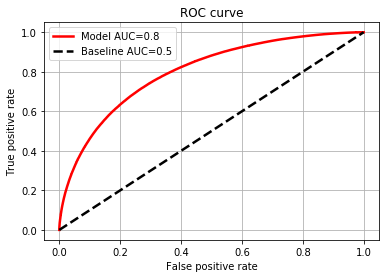

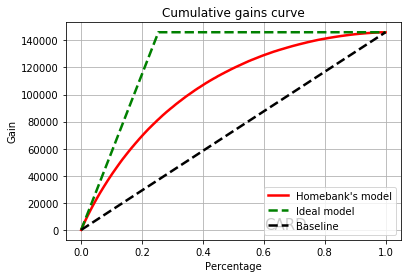

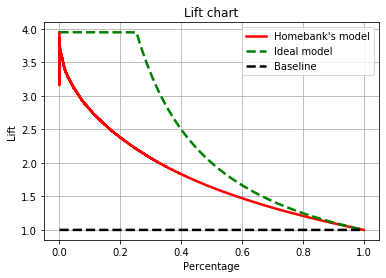

In [166]:
from util2 import plot_roc_lift as prl
prl(df.FLAG_APPLICATION, clf.predict_proba(df_ncr)[:,1])

Current size: [6.0, 4.0]


,k,lift,precision,tp,num_samples,threshold
0,10.0,2.793990,0.707692,40797.0,57648.0,0.537852
1,20.0,2.378250,0.602389,69453.0,115296.0,0.408054
2,30.0,2.071060,0.524580,90723.0,172944.0,0.317490
3,40.0,1.831533,0.463910,106974.0,230592.0,0.249748
4,50.0,1.636193,0.414432,119456.0,288240.0,0.197349
5,60.0,1.473105,0.373124,129059.0,345888.0,0.156088
6,70.0,1.331978,0.337378,136144.0,403536.0,0.122720
7,80.0,1.209191,0.306277,141250.0,461184.0,0.093070
8,90.0,1.099971,0.278612,144553.0,518832.0,0.061698
9,100.0,1.000000,0.253291,146017.0,576480.0,0.007183


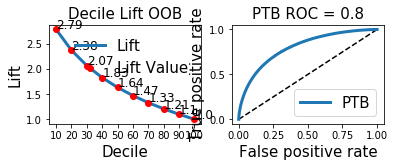

In [167]:
import sys
sys.path.append('/home/rshaimagambetov/utilities/')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df.FLAG_APPLICATION, clf.predict_proba(df_ncr)[:,1], dcl, isPlot = True)
lift_df

In [169]:
%%time
import shap
shap_test = shap.TreeExplainer(clf).shap_values(df_ncr)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 3h 55min 16s, sys: 5.18 s, total: 3h 55min 21s
Wall time: 32min 10s


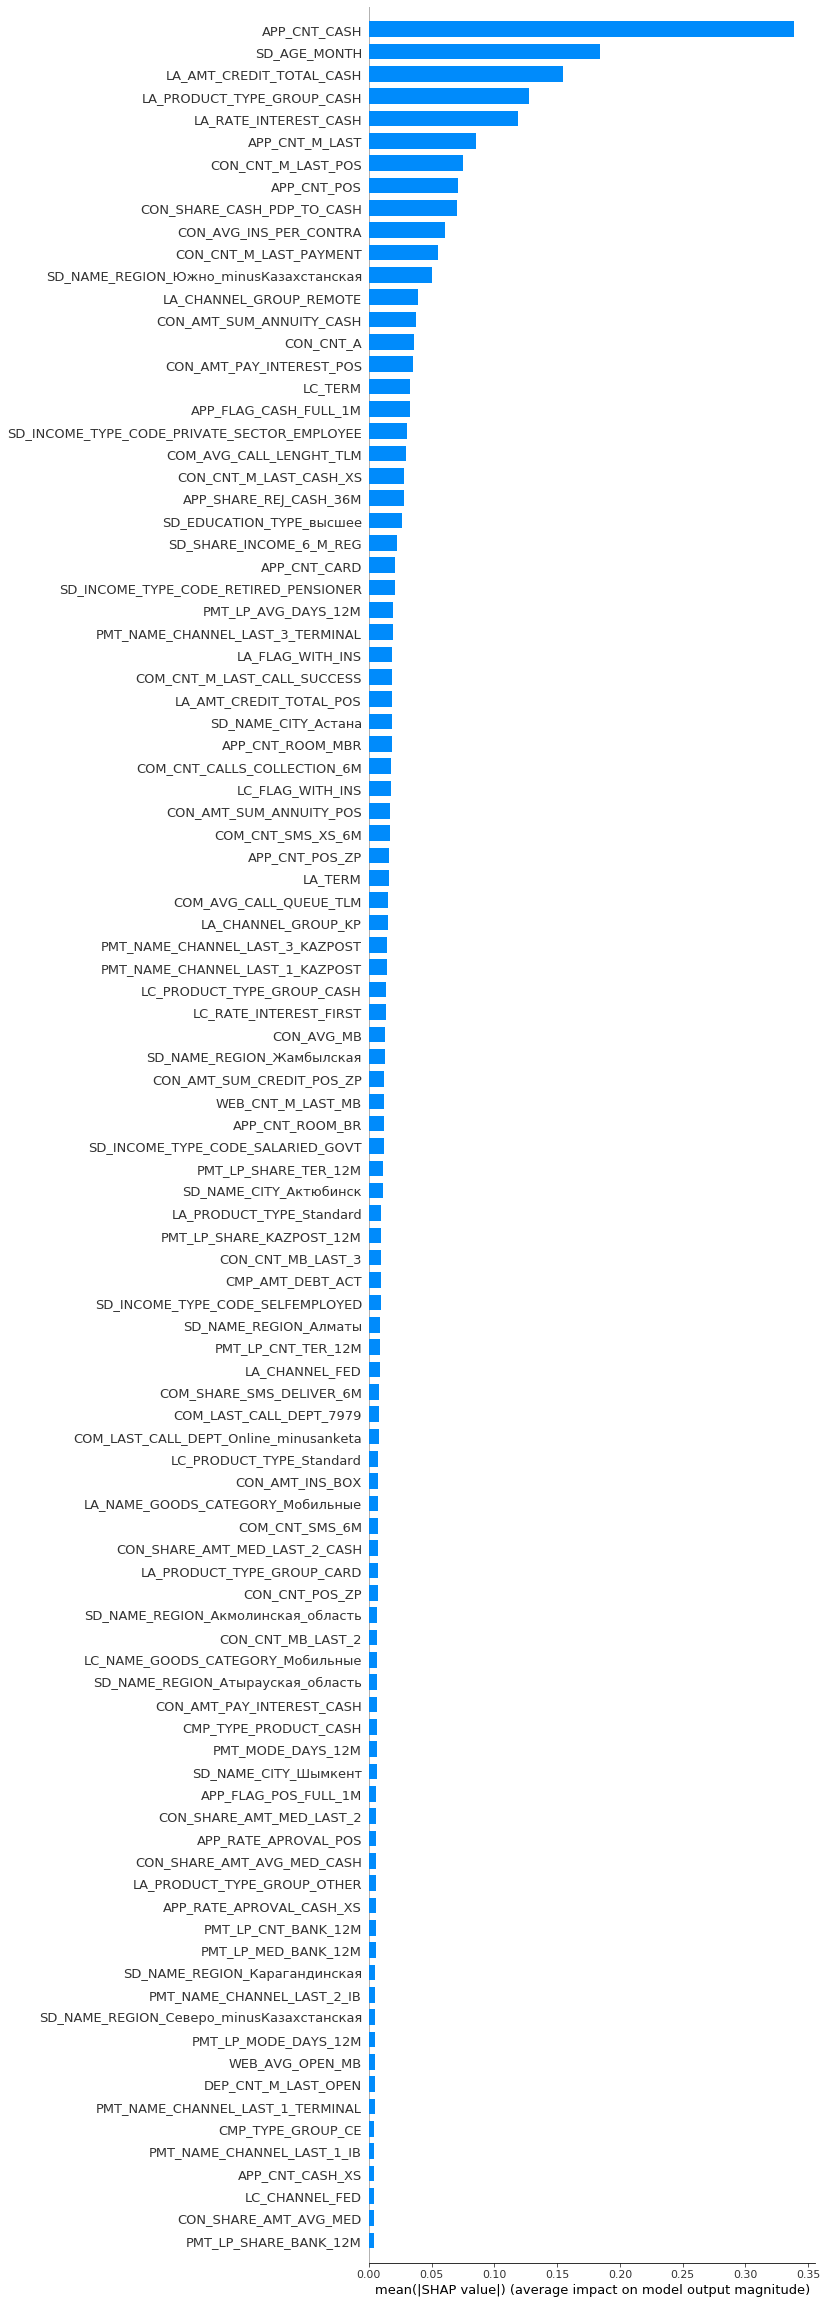

CPU times: user 3.59 s, sys: 1.67 s, total: 5.26 s
Wall time: 5.27 s


In [170]:
%%time
shap.summary_plot(shap_test,df_ncr,max_display=100, plot_type="bar")

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


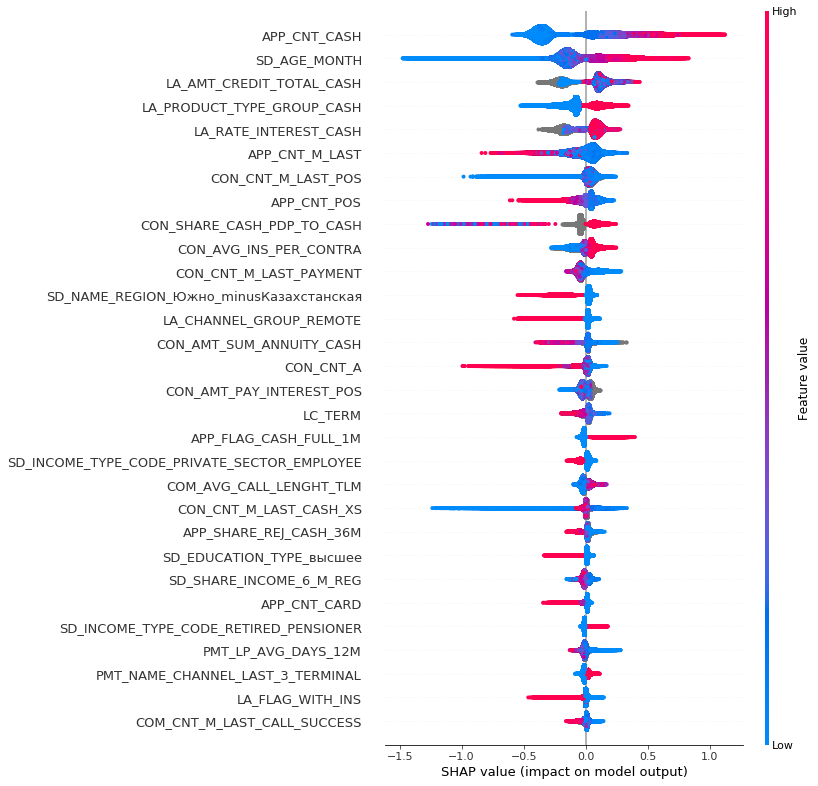

CPU times: user 6min 12s, sys: 790 ms, total: 6min 13s
Wall time: 6min 13s


In [171]:
%%time
shap.summary_plot(shap_test,df_ncr,max_display=30, auto_size_plot=True)

In [140]:
import pickle
pickle.dump(df_ncr.columns, open("/home/rshaimagambetov/SavedModels/prod_features_NON_elig_cash_09052020.dat", "wb"))
pickle.dump(clf, open("/home/rshaimagambetov/SavedModels/prod_model_NON_elig_cash_09052020.dat", "wb"))

In [1]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd
import gc, re

def prepare_df_test_real (df, features,isPrintFeatures=True, isGetDummies = True, isPrintDummies=True, trsh_hold=0.001):
    drop_feat_hcode = [
        #id
        #'MONTH_',                                        
        #'SKP_CLIENT',
        #'CMP_NAME',
        #'SD_NAME_CITY',
        #'LA_CHANNEL',
        #'LA_CHANNEL',
        #'LA_CHANNEL_GROUP',
        #'PMT_NAME_CHANNEL_LAST_1'
        #'CMP_DATE_VALID_FROM',
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT'
        #'CMP_DATE_VALID_FROM',
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT'
        #'CMP_DATE_VALID_FROM',    
        #'CMP_DATE_VALID_TO',
        #'LC_DATE_LAST_PAYMENT',
        #1
        #'CNT_CAMPAIGN',
        #'CNT_CAMPAIGN_TERM_MONTH',
        #1
        #2
        #'RATE_EIR_AVG',
        #'RATE_EIR_LOAN_FIRST',
        #'RATE_EIR_LOAN_LAST',
        #'RATE_EIR_PREV_LOAN_MAX',
        #'RATE_INTEREST_LOAN_LAST',
        #2
        #даты
        #'DATE_BCKT_1_30_OVD_LAST',
        #'DATE_BCKT_31_60_OVD_LAST',
        #'DATE_BCKT_61_90_OVD_LAST',
        #'DATE_BIRTH',
        #'DATE_TRAN_CARD_CASH_LAST',
        #'DATE_TRAN_CARD_POS_LAST'
        ]
    df.drop(drop_feat_hcode, axis=1, inplace=True)

    # Cat Features 
    # преобразовываем int to obj
    #df = df.rename(index=str, columns={"OF_CODE_SEGMENT_NEW": "OF_CODE_SEGMENT_NEW_"})

    #flag_to_obj = ['CON_NFLAG_PCCD_ALL_N','CON_NFLAG_PCCD_ACT_N', 'OF_CODE_SEGMENT_NEW_']
    #df[flag_to_obj] = df[flag_to_obj].astype(str)
    flag_to_obj = []
    
    cat_feat_objects = df.columns[df.dtypes=='object']
    #cat_feat_objects = np.concatenate([cat_feat_objects,['OF_CODE_SEGMENT_NEW_']])
    #cat_feat_nflag = df.filter(regex='.*FLAG_').columns
    #cat_feat_nflag = [x for x in cat_feat_nflag if x not in flag_to_obj]

    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(int)
    #df[cat_feat_nflag]=df[cat_feat_nflag].astype(str)

    #cat_feat_SK = df.filter(regex='.*SK.?_').columns
    #df[cat_feat_SK]=df[cat_feat_SK].astype(int)
    #df[cat_feat_SK]=df[cat_feat_SK].astype(str)

    cat_feat_all = list(set().union(cat_feat_objects))
    cat_feat_all.sort()

    df_categ_feat_ind = np.where(np.in1d(df.columns,cat_feat_all))[0]

    #isPrintFeatures= True
    if isPrintFeatures == True:
        print('[cat_feat_objects]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_objects) )
        print ('\n')

        print('[cat_feat_nflag]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_nflag) )
        print ('\n')

        print('[cat_feat_SK]')
        print('#' * 80)
        print( '\n'.join(str(p) for p in cat_feat_SK) )
        print ('\n')

        print('[cat_feat_all]')
        print('#' * 80)
        print ('\n'.join(str(p) for p in cat_feat_all) )
        print ('\n')

    #isGetDummies = True
    # Get Dummies
    df_dummy_categ_feat_ind = np.zeros([1])
    if isGetDummies == True:
        #print(list(cat_feat_all))
        cat_feat_all_dumm = pd.get_dummies(df[cat_feat_all])

        #isPrintDummies= True
        if isPrintDummies == True:
            print('#' * 80)
            print('Count dummies columns')
            print(len(cat_feat_all_dumm.columns))
            #print(list(cat_feat_all_dumm.columns))

        #trsh_hold = 0.001 if 0 - all variables
        #VarianceThreshold for CatFeatures
        #VT = VarianceThreshold(threshold=trsh_hold)
        #VT.fit(cat_feat_all_dumm)
        #VT_mask = VT.get_support()
        #print( '{} features left'.format(VT_mask.sum()))
        #print( '\n'.join(str(p) for p in cat_feat_all_dumm.columns[VT_mask]))
        
        #объединяем        
        df.drop(cat_feat_all, axis=1, inplace=True)
        df = pd.concat([df, cat_feat_all_dumm ], axis=1)
        df_dummy_categ_feat_ind = np.where(np.in1d(df.columns, cat_feat_all_dumm.columns))[0]

        #убираем спец символы из названий столбцов категорий
        df.rename(columns=lambda x: x.replace('-', '_minus'), inplace=True)
        df.rename(columns=lambda x: x.replace('+', '_plus'), inplace=True)
        df.rename(columns=lambda x: re.sub(r"[\W ]", '_', x), inplace=True)
        
        # Get missing columns in the training test
        for c in features:
            if c not in df.columns:
                #print(c)
                # Add a missing column in test set with default value equal to 0
                df[c] = 0
                
    return df, df_categ_feat_ind, df_dummy_categ_feat_ind

# Scoring 01_2020

In [142]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()
    
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    
    cursor = orcl.Cursor(connection)
    cursor.prepare('''insert into AP_CRM_ABT.T_RS_NON_ELIG_CASH_0120(skp_client,MONTH_,SCORE, SK_DATE_SCORE) values (:1, :2, :3, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)

import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'

def load_file(tile):
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    start_time = time.time()
    sql_str1 = '''select --+ parallel(2) 
    *
    from AP_CRM_ABT.T_RS_ABT_DATA_CASH_ALLSMS0120
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [143]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
#ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_ir_20190301_lern_20190521.dat", "rb"))


import pickle
clf = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_model_NON_elig_cash_09052020.dat", "rb"))
features = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_features_NON_elig_cash_09052020.dat", "rb"))


def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(1,20+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=100 )[:,1]
    #pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    #,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

1 iteration
time =  105.27846598625183
(199999, 539)
(199999, 3)
0.7298166751861572
2 iteration
time =  106.13926243782043
(200000, 539)
(200000, 3)
0.6746046543121338
3 iteration
time =  111.2534430027008
(200000, 539)
(200000, 3)
0.7493321895599365
4 iteration
time =  100.52326846122742
(200000, 539)
(200000, 3)
0.7555205821990967
5 iteration
time =  98.8965711593628
(200000, 539)
(200000, 3)
0.721411943435669
6 iteration
time =  103.45487260818481
(200000, 539)
(200000, 3)
0.6182956695556641
7 iteration
time =  105.53069400787354
(200000, 539)
(200000, 3)
0.6776459217071533
8 iteration
time =  103.80469083786011
(200000, 539)
(200000, 3)
0.7290222644805908
9 iteration
time =  123.10274815559387
(200000, 539)
(200000, 3)
1.1179656982421875
10 iteration
time =  124.01515769958496
(200000, 539)
(200000, 3)
0.8154947757720947
11 iteration
time =  110.33342504501343
(200000, 539)
(200000, 3)
0.8057868480682373
12 iteration
time =  130.30088305473328
(200000, 539)
(200000, 3)
0.7276175022

# Scoring 02_2020

In [147]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()
    
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    
    cursor = orcl.Cursor(connection)
    cursor.prepare('''insert into AP_CRM_ABT.T_RS_NON_ELIG_CASH_0220(skp_client,MONTH_,SCORE, SK_DATE_SCORE) values (:1, :2, :3, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)

import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'

def load_file(tile):
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    start_time = time.time()
    sql_str1 = '''select --+ parallel(2) 
    *
    from AP_CRM_ABT.T_RS_ABT_DATA_CASH_ALLSMS0220
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [148]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
#ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_ir_20190301_lern_20190521.dat", "rb"))


import pickle
clf = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_model_NON_elig_cash_09052020.dat", "rb"))
features = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_features_NON_elig_cash_09052020.dat", "rb"))


def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(4,20+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=100 )[:,1]
    #pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    #,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

4 iteration
time =  157.88348245620728
(220000, 539)
(220000, 3)
1.05326509475708
5 iteration
time =  162.1065902709961
(220000, 539)
(220000, 3)
1.0477163791656494
6 iteration
time =  116.30240988731384
(220000, 539)
(220000, 3)
0.9277012348175049
7 iteration
time =  126.75205183029175
(220000, 539)
(220000, 3)
1.55946683883667
8 iteration
time =  123.0415678024292
(220000, 539)
(220000, 3)
0.7785296440124512
9 iteration
time =  121.29048585891724
(220000, 539)
(220000, 3)
1.5241303443908691
10 iteration
time =  121.49640321731567
(220000, 539)
(220000, 3)
1.0078656673431396
11 iteration
time =  121.13509893417358
(220000, 539)
(220000, 3)
0.8725972175598145
12 iteration
time =  119.49701452255249
(220000, 539)
(220000, 3)
0.7473788261413574
13 iteration
time =  129.78245759010315
(220000, 539)
(220000, 3)
0.756216287612915
14 iteration
time =  120.03435492515564
(220000, 539)
(220000, 3)
0.8049132823944092
15 iteration
time =  93.80203986167908
(220000, 539)
(220000, 3)
0.81259179115

# Scoring 03_2020

In [149]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()
    
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    
    cursor = orcl.Cursor(connection)
    cursor.prepare('''insert into AP_CRM_ABT.T_RS_NON_ELIG_CASH_0320(skp_client,MONTH_,SCORE, SK_DATE_SCORE) values (:1, :2, :3, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)

import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'

def load_file(tile):
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    start_time = time.time()
    sql_str1 = '''select --+ parallel(2) 
    *
    from AP_CRM_ABT.T_RS_ABT_DATA_CASH_ALLSMS0320
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [ ]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
#ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_ir_20190301_lern_20190521.dat", "rb"))


import pickle
clf = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_model_NON_elig_cash_09052020.dat", "rb"))
features = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_features_NON_elig_cash_09052020.dat", "rb"))


def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(1,20+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=100 )[:,1]
    #pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    #,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

1 iteration


# Scoring 04_2020

In [ ]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()
    
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    
    cursor = orcl.Cursor(connection)
    cursor.prepare('''insert into AP_CRM_ABT.T_RS_NON_ELIG_CASH_0420(skp_client,MONTH_,SCORE, SK_DATE_SCORE) values (:1, :2, :3, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)

import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'

def load_file(tile):
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    start_time = time.time()
    sql_str1 = '''select --+ parallel(2) 
    *
    from AP_CRM_ABT.T_RS_ABT_DATA_CASH_ALLSMS0420
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [ ]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
#ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_ir_20190301_lern_20190521.dat", "rb"))


import pickle
clf = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_model_NON_elig_cash_09052020.dat", "rb"))
features = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_features_NON_elig_cash_09052020.dat", "rb"))


def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(1,20+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=100 )[:,1]
    #pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    #,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

# Качество на отложенной выборке

# 01.01.2020

Current size: [6.0, 4.0]


,k,lift,precision,tp,num_samples,threshold
0,10.0,2.694068,0.639308,6395.0,10003.0,0.505960
1,20.0,2.273941,0.539611,10796.0,20007.0,0.372090
2,30.0,1.995878,0.473626,14214.0,30011.0,0.283812
3,40.0,1.776964,0.421677,16873.0,40014.0,0.220425
4,50.0,1.592669,0.377944,18904.0,50018.0,0.174284
5,60.0,1.442006,0.342191,20539.0,60022.0,0.139000
6,70.0,1.310338,0.310946,21774.0,70025.0,0.109678
7,80.0,1.198722,0.284459,22765.0,80029.0,0.082505
8,90.0,1.096933,0.260305,23436.0,90033.0,0.053267
9,100.0,1.000000,0.237302,23739.0,100037.0,0.008160


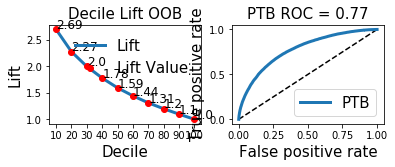

In [162]:
import pandas as pd
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
sql_str1 = '''
with s1 as (
SELECT r.*, case when t.is_cash>0 then 1 else 
                 case when t.is_cash=0 then 0 else null end end FLAG_APPLICATION
FROM T_RS_NON_ELIG_CASH_0120 r
JOIN OWNER_DWh.DC_CLIENT v ON r.SKP_CLIENT=v.SKP_CLIENT
JOIN AP_CRM_ABT.T_MZ_CLIENT_ABT_card_ATTRIBUTE a ON a.skp_client=v.skp_client
LEFT JOIN AP_CRM.T_ZB_BSL_MONITORING_EX_DM t ON t.MONTH_=a.MONTH_ and t.ID_CUID=v.ID_CUID
WHERE a.flag_eligibility_xsell=0 and a.Month_=date'2020-01-01'
)
SELECT * FROM s1
WHERE FLAG_APPLICATION is not null
'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/rshaimagambetov/utilities/')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.FLAG_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

# 01.02.2020

Current size: [6.0, 4.0]


,k,lift,precision,tp,num_samples,threshold
0,10.0,2.516005,0.673247,6684.0,9928.0,0.509450
1,20.0,2.169132,0.580429,11525.0,19856.0,0.381514
2,30.0,1.932737,0.517173,15404.0,29785.0,0.294301
3,40.0,1.731498,0.463324,18400.0,39713.0,0.229898
4,50.0,1.567132,0.419342,20817.0,49642.0,0.181133
5,60.0,1.426842,0.381803,22744.0,59570.0,0.143423
6,70.0,1.305340,0.349291,24275.0,69498.0,0.112982
7,80.0,1.197871,0.320533,25459.0,79427.0,0.084188
8,90.0,1.096899,0.293515,26227.0,89355.0,0.054043
9,100.0,1.000000,0.267586,26567.0,99284.0,0.008094


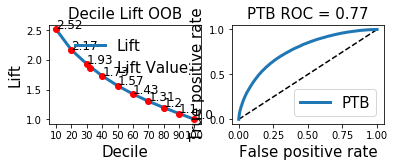

In [163]:
import pandas as pd
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
sql_str1 = '''
with s1 as (
SELECT r.*, case when t.is_cash>0 then 1 else 
                 case when t.is_cash=0 then 0 else null end end FLAG_APPLICATION
FROM T_RS_NON_ELIG_CASH_0220 r
JOIN OWNER_DWh.DC_CLIENT v ON r.SKP_CLIENT=v.SKP_CLIENT
JOIN AP_CRM_ABT.T_MZ_CLIENT_ABT_card_ATTRIBUTE a ON a.skp_client=v.skp_client
LEFT JOIN AP_CRM.T_ZB_BSL_MONITORING_EX_DM t ON t.MONTH_=a.MONTH_ and t.ID_CUID=v.ID_CUID
WHERE a.flag_eligibility_xsell=0 and a.Month_=date'2020-02-01'
)
SELECT * FROM s1
WHERE FLAG_APPLICATION is not null
'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/rshaimagambetov/utilities/')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.FLAG_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

# 01.03.2020

Current size: [6.0, 4.0]


,k,lift,precision,tp,num_samples,threshold
0,10.0,2.575718,0.648411,6121.0,9440.0,0.508553
1,20.0,2.207097,0.555614,10490.0,18880.0,0.382586
2,30.0,1.948305,0.490466,13890.0,28320.0,0.295888
3,40.0,1.734072,0.436535,16484.0,37761.0,0.233183
4,50.0,1.566101,0.394250,18609.0,47201.0,0.185164
5,60.0,1.421228,0.357780,20265.0,56641.0,0.147515
6,70.0,1.301736,0.327699,21655.0,66082.0,0.116865
7,80.0,1.194252,0.300641,22705.0,75522.0,0.089060
8,90.0,1.094850,0.275617,23417.0,84962.0,0.058455
9,100.0,1.000000,0.251740,23765.0,94403.0,0.007646


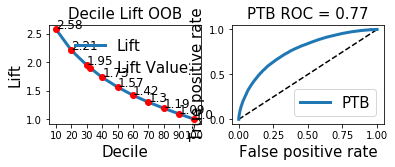

In [164]:
import pandas as pd
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
sql_str1 = '''
with s1 as (
SELECT r.*, case when t.is_cash>0 then 1 else 
                 case when t.is_cash=0 then 0 else null end end FLAG_APPLICATION
FROM T_RS_NON_ELIG_CASH_0320 r
JOIN OWNER_DWh.DC_CLIENT v ON r.SKP_CLIENT=v.SKP_CLIENT
JOIN AP_CRM_ABT.T_MZ_CLIENT_ABT_card_ATTRIBUTE a ON a.skp_client=v.skp_client
LEFT JOIN AP_CRM.T_ZB_BSL_MONITORING_EX_DM t ON t.MONTH_=a.MONTH_ and t.ID_CUID=v.ID_CUID
WHERE a.flag_eligibility_xsell=0 and a.Month_=date'2020-03-01'
)
SELECT * FROM s1
WHERE FLAG_APPLICATION is not null
'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/rshaimagambetov/utilities/')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.FLAG_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

# 01.04.2020

Current size: [6.0, 4.0]


,k,lift,precision,tp,num_samples,threshold
0,10.0,3.418347,0.590562,1314.0,2225.0,0.483028
1,20.0,2.678924,0.462817,2060.0,4451.0,0.352015
2,30.0,2.236072,0.386309,2579.0,6676.0,0.271956
3,40.0,1.898005,0.327904,2919.0,8902.0,0.213900
4,50.0,1.671261,0.288731,3213.0,11128.0,0.172281
5,60.0,1.482511,0.256122,3420.0,13353.0,0.140308
6,70.0,1.335332,0.230695,3594.0,15579.0,0.113226
7,80.0,1.207792,0.208661,3715.0,17804.0,0.089664
8,90.0,1.095817,0.189316,3792.0,20030.0,0.063136
9,100.0,1.000000,0.172762,3845.0,22256.0,0.007705


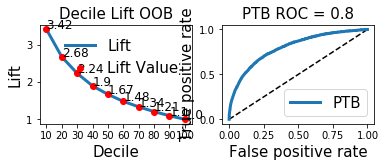

In [165]:
import pandas as pd
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
sql_str1 = '''
with s1 as (
SELECT r.*, case when t.is_cash>0 then 1 else 
                 case when t.is_cash=0 then 0 else null end end FLAG_APPLICATION
FROM T_RS_NON_ELIG_CASH_0420 r
JOIN OWNER_DWh.DC_CLIENT v ON r.SKP_CLIENT=v.SKP_CLIENT
JOIN AP_CRM_ABT.T_MZ_CLIENT_ABT_card_ATTRIBUTE a ON a.skp_client=v.skp_client
LEFT JOIN AP_CRM.T_ZB_BSL_MONITORING_EX_DM t ON t.MONTH_=a.MONTH_ and t.ID_CUID=v.ID_CUID
WHERE a.flag_eligibility_xsell=0 and a.Month_=date'2020-04-01'
)
SELECT * FROM s1
WHERE FLAG_APPLICATION is not null
'''
df_resp = pd.read_sql_query(sql_str1, connection)

import sys
sys.path.append('/home/rshaimagambetov/utilities/')
import MetricsUtils as mu
dcl = [10,20,30,40,50,60,70,80,90,100]
lift_df = mu.lift1(df_resp.FLAG_APPLICATION, df_resp.SCORE, dcl, isPlot = True)
lift_df

# Scoring 05_2020

In [172]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()
    
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    
    cursor = orcl.Cursor(connection)
    cursor.prepare('''insert into AP_CRM_ABT.T_RS_NON_ELIG_CASH_0520(skp_client,MONTH_,SCORE, SK_DATE_SCORE) values (:1, :2, :3, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)

import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'

def load_file(tile):
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    start_time = time.time()
    sql_str1 = '''select --+ parallel(2) 
    *
    from AP_CRM_ABT.T_RS_ABT_DATA_CASH_ALLSMS0520
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [173]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
#ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_ir_20190301_lern_20190521.dat", "rb"))


import pickle
clf = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_model_NON_elig_cash_09052020.dat", "rb"))
features = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_features_NON_elig_cash_09052020.dat", "rb"))


def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(1,20+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=100 )[:,1]
    #pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    #,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

1 iteration
time =  122.36592841148376
(214999, 539)
(214999, 3)
1.0748705863952637
2 iteration
time =  131.36981892585754
(215000, 539)
(215000, 3)
0.7439675331115723
3 iteration
time =  120.77233839035034
(215000, 539)
(215000, 3)
0.8370668888092041
4 iteration
time =  141.62553191184998
(215000, 539)
(215000, 3)
1.021834135055542
5 iteration
time =  124.52238893508911
(215000, 539)
(215000, 3)
1.1531352996826172
6 iteration
time =  189.94694113731384
(215000, 539)
(215000, 3)
1.448796272277832
7 iteration
time =  130.05530881881714
(215000, 539)
(215000, 3)
1.4214982986450195
8 iteration
time =  145.18816804885864
(215000, 539)
(215000, 3)
1.0000829696655273
9 iteration
time =  131.93479776382446
(215000, 539)
(215000, 3)
0.9299213886260986
10 iteration
time =  131.81862258911133
(215000, 539)
(215000, 3)
2.008517265319824
11 iteration
time =  122.58409118652344
(215000, 539)
(215000, 3)
1.2897403240203857
12 iteration
time =  132.93521928787231
(215000, 539)
(215000, 3)
0.792515039

# Scoring 06_2020

In [ ]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()
    
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    
    cursor = orcl.Cursor(connection)
    cursor.prepare('''insert into AP_CRM_ABT.T_RS_NON_ELIG_CASH_0620(skp_client,MONTH_,SCORE, SK_DATE_SCORE) values (:1, :2, :3, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)

import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'

def load_file(tile):
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    start_time = time.time()
    sql_str1 = '''select --+ parallel(2) 
    *
    from AP_CRM_ABT.T_RS_ABT_DATA_CASH_ALLSMS0620
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [ ]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
#ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_ir_20190301_lern_20190521.dat", "rb"))


import pickle
clf = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_model_NON_elig_cash_09052020.dat", "rb"))
features = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_features_NON_elig_cash_09052020.dat", "rb"))


def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(1,20+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=100 )[:,1]
    #pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    #,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

# Scoring 07_2020

In [2]:
def save_file(df, sk_date_score):
    start_time = time.time()
    
    rows = df.to_records(index=False).tolist()
    
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    
    cursor = orcl.Cursor(connection)
    cursor.prepare('''insert into AP_CRM_ABT.T_RS_NON_ELIG_CASH_0720(skp_client,MONTH_,SCORE, SK_DATE_SCORE) values (:1, :2, :3, ''' + str(sk_date_score) +''')''')
    cursor.executemany(None, rows)
    connection.commit()
    
    end_time = time.time()
    return (end_time-start_time)

import pandas as pd
import os
import cx_Oracle as orcl
connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
os.environ['NLS_LANG'] = 'Russian.AL32UTF8'

def load_file(tile):
    connection = orcl.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')
    os.environ['NLS_LANG'] = 'Russian.AL32UTF8'
    start_time = time.time()
    sql_str1 = '''select --+ parallel(2) 
    *
    from AP_CRM_ABT.T_RS_ABT_DATA_CASH_ALLSMS0720
     WHERE n_tile={}'''.format(tile)
    df = pd.read_sql_query(sql_str1, connection)
    end_time = time.time()
    return (df,end_time-start_time)

In [3]:
%%time
import time
import numpy as np
import pandas as pd
import gc, re

#обучена на 01.0.201
#ir = pickle.load(open("/home/python/RSHAYMAGAMBETOV/Model_card/SavedModels/prod_cash_ir_20190301_lern_20190521.dat", "rb"))


import pickle
clf = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_model_NON_elig_cash_09052020.dat", "rb"))
features = pickle.load(open("/home/rshaimagambetov/SavedModels/prod_features_NON_elig_cash_09052020.dat", "rb"))


def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

for i in range(1,20+1):
    print( '{} iteration'.format(i))
    df_fin, time_load = load_file(i)
    print( 'time = ',time_load)

    #cat_features = pd.get_dummies(df_fin[cat_feat])
    #df_fin = df_fin.drop(cat_feat,axis = 1)
    #df_fin, _ , _ = prepare_df(df_fin,trsh_hold=0.001, isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #df_fin, df_categ_feat_ind, df_dummy_categ_feat_ind = prepare_df(df_fin,trsh_hold=0.001,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    df_fin, _ , _ = prepare_df_test_real(df_fin, features,isPrintFeatures=False, isGetDummies = True, isPrintDummies=False)
    #target_fin = df_fin.IND_FULL_APP
    #cuid = df_fin.ID_CUID
    cuid = df_fin['SKP_CLIENT']
    #skp_campaign = df_fin['SKP_CAMPAIGN']
    date_month_valid_from = df_fin['MONTH_']
    #id_source = df_fin[ 'ID_SOURCE' ] 
    
    df_fin = df_fin[features]
    #gc.collect()
    X_oob = df_fin#.drop(['IND_FULL_APP'],axis=1)
    #Y_oob = df_fin.IND_FULL_APP
    
    print(X_oob.shape)
    
    #df_fin = df_fin.drop(['IND_FULL_APP','ID_CUID'],axis = 1)
    #df_fin = pd.concat([df_fin, cat_features[used_cat_cols]], axis=1)
    #df_fin = df_fin.drop(check_arr,axis=1)
    
    #-----------------------------------
    #pred = clf.predict_proba(df_fin.loc[:, selected_features])
    #pred_oob_xgb = xgp_feat_imp.predict(xgb.DMatrix(X_oob), ntree_limit=497+1)
    pred_oob_xgb =clf.predict_proba(X_oob, ntree_limit=100 )[:,1]
    #pred_oob_xgb_calibr = ir.transform(pred_oob_xgb)
    
    
    df1 = pd.concat([pd.DataFrame(cuid.values, columns=['SKP_CLIENT']).reset_index(drop=True), 
                     #pd.DataFrame(skp_campaign.values, columns=['SKP_CAMPAIGN']).reset_index(drop=True),
                    #pd.DataFrame(id_source.values, columns=['ID_SOURCE']).reset_index(drop=True),
                     pd.DataFrame(date_month_valid_from.apply(lambda x: to_integer(x)).values, columns=['MONTH_']).reset_index(drop=True),
                     pd.DataFrame(pred_oob_xgb, columns=['SCORE']).reset_index(drop=True)
                    #,pd.DataFrame(pred_oob_xgb_calibr, columns=['SCORE_CL']).reset_index(drop=True)
                    ], axis=1)
    print(df1.shape)
    #print 'roc-auc = ',metrics.roc_auc_score(target_fin, pred[:,1])
    #df = pd.DataFrame({'ID_CUID':cuid.values, 'score':pred[:,1],'IND_FULL_APP':target_fin})
    
    time_save = save_file(df1, to_integer(pd.to_datetime('today')))
    
    print (time_save)

1 iteration
time =  224.5926434993744
(214999, 539)
(214999, 3)
0.8559818267822266
2 iteration
time =  193.57450652122498
(215000, 539)
(215000, 3)
1.385556936264038
3 iteration
time =  216.44866633415222
(215000, 539)
(215000, 3)
0.8468916416168213
4 iteration
time =  191.74043893814087
(215000, 539)
(215000, 3)
1.1940841674804688
5 iteration
time =  159.1566822528839
(215000, 539)
(215000, 3)
0.8369252681732178
6 iteration
time =  156.6067132949829
(215000, 539)
(215000, 3)
1.3340466022491455
7 iteration
time =  161.4800741672516
(215000, 539)
(215000, 3)
1.3170480728149414
8 iteration
time =  127.89743828773499
(215000, 539)
(215000, 3)
0.9461073875427246
9 iteration
time =  143.17597317695618
(215000, 539)
(215000, 3)
0.7978689670562744
10 iteration
time =  113.76395225524902
(215000, 539)
(215000, 3)
0.7450268268585205
11 iteration
time =  111.43580460548401
(215000, 539)
(215000, 3)
0.7401156425476074
12 iteration
time =  144.7067995071411
(215000, 539)
(215000, 3)
1.269516706466

In [161]:
1+1

2

In [30]:
import lightgbm as lgb

In [31]:
score_lgb=[]
params_lgb=[]
def hyperopt_lgb_score(params):
    clf = lgb.LGBMClassifier(params)
    current_score = cross_val_score(clf, df_ncr, target, scoring='roc_auc',cv=custom_cv()).mean()
    print(current_score, params)
    score_lgb.append(current_score)
    params_lgb.append(params)
    return -current_score

In [32]:
space_lgb = {
            'n_estimators': hp.choice('n_estimators', range(50, 55)),
            'max_depth':  hp.choice('max_depth', np.arange(1, 4, dtype=int)),
            #'n_jobs': 8
        }

In [33]:
%%time
x1=time.time()
best = fmin(fn=hyperopt_lgb_score, space=space_lgb, algo=tpe.suggest, max_evals=3)
x2=time.time()

nan                                                  
{'max_depth': 3, 'n_estimators': 54}                 
nan                                                             
{'max_depth': 3, 'n_estimators': 50}                            
nan                                                             
{'max_depth': 1, 'n_estimators': 51}                            
100%|██████████| 3/3 [01:09<00:00, 23.31s/trial, best loss: nan]


AllTrialsFailed: 

In [42]:
import sys
# sys.setdefaultencoding() does not exist, here!
#reload(sys)  # Reload does the trick!
sys.getdefaultencoding()

'utf-8'

In [43]:
clf1 = lgb.LGBMClassifier()

In [44]:
# -*- coding: utf-8 -*-
clf1.fit(df_ncr.sample(frac=0.01),target.sample(frac=0.01))

LightGBMError: Do not support non-ascii characters in feature name.

In [37]:
df_ncr.columns.tolist()

['SD_AMT_INCOME_OTHER',
 'SD_AGE_MONTH',
 'SD_CNT_CHILDREN',
 'SD_SHARE_INCOME_6_M_REG',
 'CMP_FLAG_RD_POOL',
 'CMP_AMT_DEBT_ACT',
 'APP_CNT_M_LAST',
 'APP_RATE_APROVAL_POS',
 'APP_RATE_APROVAL_CASH_XS',
 'APP_CNT_POS',
 'APP_CNT_CASH',
 'APP_CNT_CARD',
 'APP_CNT_CASH_XS',
 'APP_CNT_CARD_XS',
 'APP_CNT_POS_ZP',
 'APP_FLAG_CASH_FULL_1M',
 'APP_FLAG_CARD_FULL_1M',
 'APP_FLAG_CARD_BOOK_1M',
 'APP_FLAG_POS_FULL_1M',
 'APP_FLAG_CASH_FULL_CT',
 'APP_FLAG_CASH_BOOK_CT',
 'APP_FLAG_CARD_FULL_CT',
 'APP_FLAG_CARD_BOOK_CT',
 'APP_FLAG_POS_BOOK_CT',
 'APP_SHARE_REJ_CASH_36M',
 'APP_CNT_ROOM_MBR',
 'APP_CNT_ROOM_BR',
 'LA_TERM',
 'LA_FLAG_WITH_INS',
 'LA_FLAG_WITH_INS_BOX',
 'LA_RATE_INTEREST_CASH',
 'LA_AMT_CREDIT_TOTAL_CASH',
 'LA_AMT_CREDIT_TOTAL_POS',
 'LC_FLAG_WITH_INS',
 'LC_FLAG_WITH_INS_BOX',
 'LC_RATE_INTEREST_FIRST',
 'LC_RATE_INTEREST_CASH_XS',
 'LC_TERM',
 'CON_CNT_M_LAST_CASH_XS',
 'CON_CNT_M_LAST_POS',
 'CON_CNT_CARD',
 'CON_CNT_CARD_XS',
 'CON_CNT_POS_ZP',
 'CON_CNT_CARD_DEBIT',
 'C

In [46]:
ord(df_ncr.columns.tolist()[0][0])

83

In [48]:
for i in df_ncr.columns.tolist():
    for j in i:
        print(ord(j))

83
68
95
65
77
84
95
73
78
67
79
77
69
95
79
84
72
69
82
83
68
95
65
71
69
95
77
79
78
84
72
83
68
95
67
78
84
95
67
72
73
76
68
82
69
78
83
68
95
83
72
65
82
69
95
73
78
67
79
77
69
95
54
95
77
95
82
69
71
67
77
80
95
70
76
65
71
95
82
68
95
80
79
79
76
67
77
80
95
65
77
84
95
68
69
66
84
95
65
67
84
65
80
80
95
67
78
84
95
77
95
76
65
83
84
65
80
80
95
82
65
84
69
95
65
80
82
79
86
65
76
95
80
79
83
65
80
80
95
82
65
84
69
95
65
80
82
79
86
65
76
95
67
65
83
72
95
88
83
65
80
80
95
67
78
84
95
80
79
83
65
80
80
95
67
78
84
95
67
65
83
72
65
80
80
95
67
78
84
95
67
65
82
68
65
80
80
95
67
78
84
95
67
65
83
72
95
88
83
65
80
80
95
67
78
84
95
67
65
82
68
95
88
83
65
80
80
95
67
78
84
95
80
79
83
95
90
80
65
80
80
95
70
76
65
71
95
67
65
83
72
95
70
85
76
76
95
49
77
65
80
80
95
70
76
65
71
95
67
65
82
68
95
70
85
76
76
95
49
77
65
80
80
95
70
76
65
71
95
67
65
82
68
95
66
79
79
75
95
49
77
65
80
80
95
70
76
65
71
95
80
79
83
95
70
85
76
76
95
49
77
65
80
80
95
70
76
65
71
95
67
65
83
7

In [1]:
import cx_Oracle
con1 = cx_Oracle.connect('HCKZ_RSHAIMAGAMBETOV[AP_CRM_ABT]/nSQF8BD8US1T@10.13.24.12:1521/HDWKZ.KZ.PROD',encoding='UTF-8', nencoding='UTF-8')

In [3]:
%%time
import pandas as pd
sql_str1 ='''
with s1 as(
SELECT t.skp_client,t.score crm_score_wi,r.score risk_score,risk_grade 
FROM ap_crm_abt.t_rs_non_elig_cash_0520 t
JOIN ap_risk.ob_last_rep_day_eligibility r
ON t.skp_client=r.skp_client
),s2 as (
SELECT risk_grade, risk_score,crm_score_wi,NTILE(10) OVER(ORDER BY risk_score DESC) risk_score_ntile_10,NTILE(10) OVER(ORDER BY crm_score_wi DESC) crm_score_ntile_10 FROM s1
)
SELECT * FROM s2

'''
df = pd.read_sql_query(sql_str1, con1)
df_query = df.copy()

CPU times: user 23.4 s, sys: 3.31 s, total: 26.7 s
Wall time: 1min 15s


In [4]:
df.head()

,RISK_GRADE,RISK_SCORE,CRM_SCORE_WI,RISK_SCORE_NTILE_10,CRM_SCORE_NTILE_10
0,D,0.043841,0.926401,7,1
1,G,0.077456,0.915322,4,1
2,C,0.029460,0.913591,8,1
3,G,0.081367,0.911936,4,1
4,H,0.152732,0.909745,2,1


In [8]:
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr

In [9]:
pearsonr(df.RISK_SCORE,df.CRM_SCORE_WI)

(-0.13215174631208743, 0.0)

In [10]:
spearmanr(df.RISK_SCORE,df.CRM_SCORE_WI)

SpearmanrResult(correlation=-0.13201200769765095, pvalue=0.0)

In [36]:
pearsonr(df[df.CRM_SCORE_NTILE_10==1].RISK_SCORE,df[df.CRM_SCORE_NTILE_10==1].CRM_SCORE_WI)

(-0.09997981567665995, 0.0)

In [20]:
spearmanr(df[df.CRM_SCORE_NTILE_10==1].RISK_SCORE,df[df.CRM_SCORE_NTILE_10==1].CRM_SCORE_WI)

SpearmanrResult(correlation=-0.11768553491122452, pvalue=0.0)

In [21]:
pearsonr(df[df.RISK_SCORE_NTILE_10==10].RISK_SCORE,df[df.RISK_SCORE_NTILE_10==10].CRM_SCORE_WI)

(0.003250387096835866, 0.032575093781259376)

In [22]:
spearmanr(df[df.RISK_SCORE_NTILE_10==10].RISK_SCORE,df[df.RISK_SCORE_NTILE_10==10].CRM_SCORE_WI)

SpearmanrResult(correlation=0.028566650028221695, pvalue=9.522956196401579e-79)

In [23]:
pearsonr(df[df.RISK_GRADE=='A'].RISK_SCORE,df[df.RISK_GRADE=='A'].CRM_SCORE_WI)

(0.012068388299398235, 5.265307745301001e-10)

In [24]:
spearmanr(df[df.RISK_GRADE=='A'].RISK_SCORE,df[df.RISK_GRADE=='A'].CRM_SCORE_WI)

SpearmanrResult(correlation=0.02512946123786803, pvalue=2.8775556275513226e-38)

In [25]:
pearsonr(df[df.RISK_GRADE=='H'].RISK_SCORE,df[df.RISK_GRADE=='H'].CRM_SCORE_WI)

(-0.08089066233642658, 0.0)

In [26]:
spearmanr(df[df.RISK_GRADE=='H'].RISK_SCORE,df[df.RISK_GRADE=='H'].CRM_SCORE_WI)

SpearmanrResult(correlation=-0.06291449412580197, pvalue=0.0)